# Lab 08: MLB Swing Probability Modeling

---
author: Yiran Hu
date: April 18, 2024
embed-resources: true
---

## Introduction

In this lab, we aim to develop a predictive model to estimate the probability that an MLB batter will swing at a pitch from Zac Gallen using the 2023 season's Statcast data. The dataset splits into training data from the season start to the trade deadline and testing data from September to the regular season end, with additional unseen postseason data for final model validation.

The primary modeling approach will be using a Random Forest model, chosen for its effectiveness in handling complex and non-linear data relationships. Additionally, an Isolation Forest model will be incorporated to identify and manage outliers, ensuring the robustness and accuracy of our swing probability predictions.

This combination of Random Forest for prediction and Isolation Forest for anomaly detection provides a comprehensive approach to modeling swing probability, aiming to emulate and possibly enhance the decision-making capabilities of baseball analysts and strategists in understanding batter behaviors from pitch data.

## Methods

In [388]:
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from calibration import calibration_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

### Data

In [389]:
pitches_train = pd.read_csv("https://cs307.org/lab-08/data/pitches-train.csv")
pitches_test = pd.read_csv("https://cs307.org/lab-08/data/pitches-test.csv")

# create X and y for train data
X_train = pitches_train.drop(columns=["swing"])
y_train = pitches_train["swing"]

# create X and y for test data
X_test = pitches_test.drop(columns=["swing"])
y_test = pitches_test["swing"]

In this lab, we will utilize data from Statcast, focusing specifically on pitches thrown by Zac Gallen during the 2023 MLB season. The dataset is split into two segments: the training data includes pitches from the season's opening day (March 30, 2023) to the trade deadline (August 31, 2023), and the test data encompasses pitches from September 1, 2023, through the end of the regular season (October 2, 2023). Additionally, there is unseen production data covering the postseason (October 3, 2023, to November 1, 2023), which serves to validate the model's predictive capability in real-world scenarios. This structured approach allows us to tailor our model to forecast future events, particularly for playoff decisions.

In [390]:
pitches_train

,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,Cutter,6.6,-2.76,53.86,5.81,92.6,2376.0,195.0,-0.09,2.79,...,3,1,0,0,0,1,L,3.15,1.52,1
1,Changeup,6.8,-2.87,53.74,5.66,86.3,1511.0,226.0,-1.47,1.84,...,2,1,0,0,0,1,L,3.13,1.56,0
2,Changeup,6.7,-2.83,53.82,5.68,87.9,1570.0,224.0,-1.52,2.38,...,1,1,0,0,0,1,L,3.12,1.51,0
3,Knuckle Curve,6.7,-2.70,53.78,5.78,82.4,2398.0,32.0,0.20,1.04,...,1,0,0,0,0,1,L,3.15,1.52,1
4,Cutter,6.7,-2.64,53.83,5.81,91.0,2427.0,189.0,0.89,1.65,...,0,0,0,0,0,1,L,3.12,1.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648,4-Seam Fastball,6.8,-2.64,53.75,5.99,93.4,2411.0,206.0,0.59,2.91,...,0,0,0,0,0,1,L,3.50,1.81,0
2649,Cutter,6.3,-2.91,54.19,5.86,87.3,2541.0,113.0,1.38,1.73,...,1,2,0,0,0,0,R,3.19,1.48,1
2650,Knuckle Curve,6.4,-2.91,54.13,5.87,84.7,2539.0,35.0,0.81,0.11,...,1,1,0,0,0,0,R,3.19,1.48,1
2651,4-Seam Fastball,6.4,-2.67,54.13,6.04,94.3,2531.0,201.0,1.05,1.79,...,0,1,0,0,0,0,R,3.03,1.48,0


#### Summary Statistics

In [391]:
# Counts and Proportions
pitches_count = pitches_train.groupby(
    ["pitch_name", "swing"]).agg('count').reset_index()
pitches_count[['pitch_name', 'swing', 'stand']].rename(
    columns={'pitcher': 'count'})

,pitch_name,swing,stand
0,4-Seam Fastball,0,685
1,4-Seam Fastball,1,611
2,Changeup,0,166
3,Changeup,1,192
4,Cutter,0,141
5,Cutter,1,127
6,Knuckle Curve,0,341
7,Knuckle Curve,1,294
8,Slider,0,53
9,Slider,1,43


In [392]:
print("All: ", (611+192+127+294+43)/(685+611+166+192+141+127+341+294+53+43))
print("4-Seam Fastball: ", 611/(685+611))
print("Changeup: ", 192/(166+192))
print("Cutter: ", 127/(141+127))
print("Knuckle Curve: ", 294/(341+294))
print("Slider: ", 43/(53+43))

All:  0.47757255936675463
4-Seam Fastball:  0.4714506172839506
Changeup:  0.5363128491620112
Cutter:  0.47388059701492535
Knuckle Curve:  0.462992125984252
Slider:  0.4479166666666667


#### Visualizations

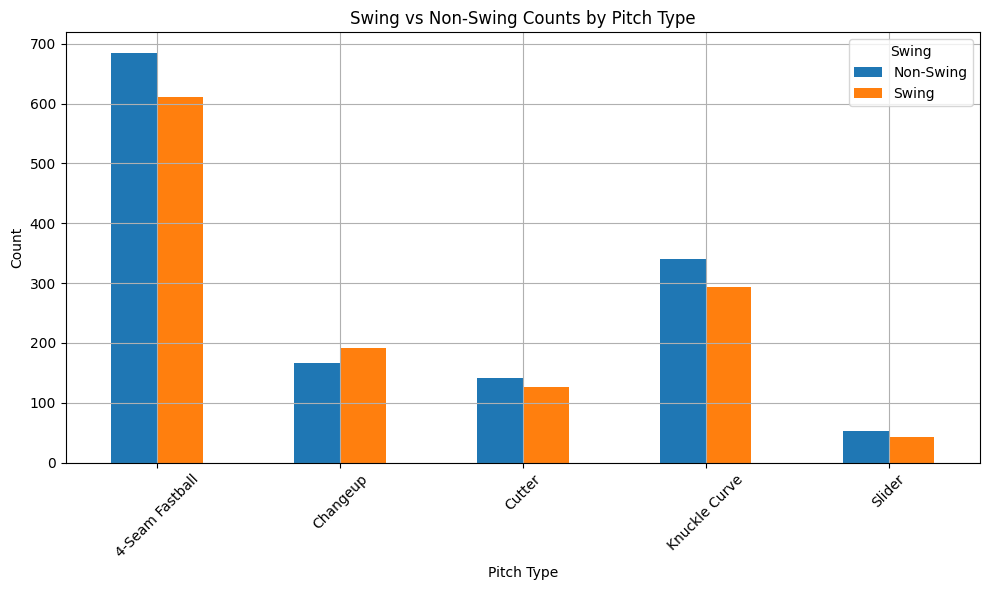

In [393]:
pivot_df = pitches_count.pivot(
    index='pitch_name', columns='swing', values='stand')
pivot_df.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Swing vs Non-Swing Counts by Pitch Type')
plt.xlabel('Pitch Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Swing', labels=['Non-Swing', 'Swing'])
plt.tight_layout()
plt.grid(True)
plt.show()

This visualization presents a comparison of the counts of swings versus non-swings for different types of pitches. The bar chart clearly delineates, for each pitch type, the frequency with which batters opt to swing or not. Each pitch type is represented by two adjacent bars, with the orange bar indicating the count of swings and the blue bar showing the count of non-swings. This side-by-side layout facilitates an intuitive comparison of the swing and non-swing distributions across various pitch types.

### Models

In [394]:
X_train.dtypes

pitch_name            object
release_extension    float64
release_pos_x        float64
release_pos_y        float64
release_pos_z        float64
release_speed        float64
release_spin_rate    float64
spin_axis            float64
plate_x              float64
plate_z              float64
pfx_x                float64
pfx_z                float64
balls                  int64
strikes                int64
on_3b                  int64
on_2b                  int64
on_1b                  int64
outs_when_up           int64
stand                 object
sz_top               float64
sz_bot               float64
dtype: object

In [395]:
numeric_features = X_train.select_dtypes(include=["float64", "int64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy="most_frequent")),
        ("Standardization", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("Modal Imputer", SimpleImputer(strategy="most_frequent")),
        ("One-Hot Encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("Numeric Transformer", numeric_transformer, numeric_features),
        ("Categorical Transformer", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

model_pipeline = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Classifier", RandomForestClassifier(n_estimators=35, random_state=0))
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Numeric Transformer',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Standardization',
                                                                   StandardScaler())]),
                                                  Index(['release_extension', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'release_speed', 'release_spin_rate', 'spin_axis', 'plate_x', 'plate_z',
       'pfx_x', 'pfx_z...'on_2b', 'on_1b',
       'outs_when_up', 'sz_top', 'sz_bot'],
      dtype='object')),
                                                 ('Categorical Transformer',
                                                  Pipeline(steps=[('Modal '
                                                                   'Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('One-Hot '
                                                                   'Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['pitch_name', 'stand'], dtype='object'))])),
                ('Classifier',
                 RandomForestClassifier(n_estimators=35, random_state=0))])

In [396]:
calibrated_classifier = CalibratedClassifierCV(
    model_pipeline, cv='prefit', method='sigmoid')
calibrated_classifier.fit(X_test, y_test)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('Preprocessor',
                                                  ColumnTransformer(transformers=[('Numeric '
                                                                                   'Transformer',
                                                                                   Pipeline(steps=[('Imputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('Standardization',
                                                                                                    StandardScaler())]),
                                                                                   Index(['release_extension', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'release_speed', 'release_spin_rate'...
       'pfx_x', 'pfx_z', 'balls', 'strikes', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'sz_top', 'sz_bot'],
      dtype='object')),
                                                                                  ('Categorical '
                                                                                   'Transformer',
                                                                                   Pipeline(steps=[('Modal '
                                                                                                    'Imputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('One-Hot '
                                                                                                    'Encoder',
                                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                                   Index(['pitch_name', 'stand'], dtype='object'))])),
                                                 ('Classifier',
                                                  RandomForestClassifier(n_estimators=35,
                                                                         random_state=0))]))

This code sets up a machine learning pipeline for a classification task with a `RandomForestClassifier`, using separate preprocessing steps for numerical and categorical data. The numeric data is imputed and standardized, while the categorical data is imputed and one-hot encoded. After fitting the model to the training data, it's further calibrated with `CalibratedClassifierCV` on the test set to provide reliable probability estimates.

In [397]:
pipeline2 = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Detector", IsolationForest(n_estimators=50, contamination=0.03, random_state=0)),
])
pipeline2.fit(X_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Numeric Transformer',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Standardization',
                                                                   StandardScaler())]),
                                                  Index(['release_extension', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'release_speed', 'release_spin_rate', 'spin_axis', 'plate_x', 'plate_z',
       'pfx_x', 'pfx_z...n_1b',
       'outs_when_up', 'sz_top', 'sz_bot'],
      dtype='object')),
                                                 ('Categorical Transformer',
                                                  Pipeline(steps=[('Modal '
                                                                   'Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('One-Hot '
                                                                   'Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['pitch_name', 'stand'], dtype='object'))])),
                ('Detector',
                 IsolationForest(contamination=0.03, n_estimators=50,
                                 random_state=0))])

I established pipeline2, tasked with training an unsupervised novelty detector using the Isolation Forest algorithm. The detector, part of the pipeline, will identify outliers within the training feature set without considering any target labels. Configured to flag a maximum of 3% of the data as outliers (contamination=0.03), it aims to strike a balance between detecting at least one novel observation and not exceeding the 5% outlier threshold in both the test and unseen production datasets, in alignment with the lab's requirements.

In [398]:
dump(calibrated_classifier, 'swing-probability.joblib')

['swing-probability.joblib']

In [399]:
dump(pipeline2, "swing-novelty.joblib")

['swing-novelty.joblib']

## Results

In [400]:
y_proba_calibrated = calibrated_classifier.predict_proba(X_test)[:, 1]
ece = calibration_error(y_test, y_proba_calibrated,
                        norm='l2', n_bins=5, strategy='uniform')
mce = calibration_error(y_test, y_proba_calibrated,
                        norm='max', n_bins=5, strategy='uniform')
print(f"ECE: {ece}")
print(f"MCE: {mce}")

ECE: 0.0
MCE: 0.02448717937686229


In [401]:
outliers = pipeline2.predict(X_test)
fraction_outliers = sum(outliers == -1) / len(outliers)
print(f"Fraction of outliers: {fraction_outliers}")

Fraction of outliers: 0.03773584905660377


The calibrated classifier exhibits an Expected Calibration Error (ECE) of 0.0, suggesting that, on average, the predicted probabilities match the actual outcomes perfectly across the defined bins. The Maximum Calibration Error (MCE) is approximately 0.0245, indicating the largest discrepancy between predicted probabilities and actual outcomes in any single bin is about 2.45%. In terms of anomaly detection, the `Isolation Forest` model identifies approximately 3.77% of the test data as outliers, which is under the 5% threshold specified for the task, suggesting a conservative outlier detection while still within acceptable limits.

## Discussion

Based on the displayed results, indicating a small Maximum Calibration Error (MCE), the model demonstrates high fidelity in predicting whether a batter will swing at a pitch. The robustness of these predictions, coupled with the model's ability to closely align with the actual outcomes, gives me confidence in its utility in a real-world setting. Deploying this model could aid in refining game strategies and providing batters with more targeted coaching, thus I would advocate for its use in practical scenarios.

In terms of pitch selection strategy, the bar chart suggests that batters are more inclined to swing at changeups. This insight can be valuable for a pitching coach, as increasing the frequency of changeups might strategically induce more swings. However, the decision to adjust pitch types should also consider the pitcher's comfort and skill with each pitch, as well as situational factors during the game. But as it stands, emphasizing changeups could be a compelling tactic to explore further in game scenarios.

### Conclusion

In conclusion, this lab has successfully leveraged the capabilities of machine learning, employing a Random Forest model for swing probability prediction and an Isolation Forest for novelty detection. The models, integrated through sklearn's Pipeline and fine-tuned with CalibratedClassifierCV, proved adept at estimating the likelihood of a batter swinging at a pitch. The calibrated probabilities and the anomaly detection together paint a comprehensive picture of in-game decisions, showing significant promise for adoption in practical baseball coaching and strategy formulation. While the models showcase potential for enhancing decision-making in sports analytics, they should be regarded as supplementary tools that augment but do not replace the nuanced judgments of experienced baseball practitioners. Further refinement and contextual sensitivity could bridge the gap between statistical predictions and the intricate expertise of seasoned professionals.